In [2]:
def start_signature():
    print("="*40)
    print("START OF NOTEBOOK — AT")
    print("="*40)

start_signature()


START OF NOTEBOOK — AT


In [ ]:
import pandas as pd
import numpy as np

# lets look at the base table - transfers 
df_transfers = pd.read_csv(r'C:\Users\arpitha_work\Downloads\TRU MSCDS\Sem 3\Graduate Project\MIMIC\mimic-iv-3.1\hosp\transfers.csv')
df_transfers.head()

In [74]:
# I want to know the unique number of patients and unique admissions 

unique_patients = df_transfers["subject_id"].nunique()
unique_admissions = df_transfers["hadm_id"].nunique()
unique_transfers = df_transfers["transfer_id"].nunique()
print("the no of unique patients :", unique_patients)
print(" the no of unique admissions :", unique_admissions)
print(" the no of unique transfers :", unique_transfers)

the no of unique patients : 364627
 the no of unique admissions : 546024
 the no of unique transfers : 2413581


In [75]:
df_transfers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2413581 entries, 0 to 2413580
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   subject_id   int64  
 1   hadm_id      float64
 2   transfer_id  int64  
 3   eventtype    object 
 4   careunit     object 
 5   intime       object 
 6   outtime      object 
dtypes: float64(1), int64(2), object(4)
memory usage: 128.9+ MB


In [76]:
# i am gonna calculate our output variable now - time spent in ED. Now for that first I need only ED data , everything else not needed so need to remove that
# Secondly remove any blank values and then create a new variable called LOS_ED - length of stay in ED
# Goal is to predict how long a patient will stay in the ED during a single hospital visit, so we will  use the admission level.
# LOS_ED_houurs - defined as the time spent by a patient in emergency department calculated by the difference between intime and outtime 

units = ['Hematology/Oncology']
df_transfers = df_transfers[df_transfers['careunit'].isin(units)].copy()
# df_transfers = df_transfers.dropna(subset =['intime','outtime'])

In [77]:
df_transfers.head()

,subject_id,hadm_id,transfer_id,eventtype,careunit,intime,outtime
145,10000935,25849114.0,34728994,transfer,Hematology/Oncology,2187-10-23 12:35:52,2187-10-26 17:28:34
148,10000935,25849114.0,39764621,transfer,Hematology/Oncology,2187-10-22 18:28:58,2187-10-23 12:35:52
265,10001401,24818636.0,30921571,transfer,Hematology/Oncology,2131-07-31 00:00:55,2131-07-31 08:15:20
266,10001401,24818636.0,35059272,transfer,Hematology/Oncology,2131-07-31 18:58:22,2131-08-04 14:33:42
268,10001401,24818636.0,36154494,transfer,Hematology/Oncology,2131-07-31 08:15:20,2131-07-31 18:58:22


In [78]:
# now lets keep datetime format and calculate LOS_HC (hours)
df_transfers['intime'] = pd.to_datetime(df_transfers['intime'])
df_transfers['outtime'] = pd.to_datetime(df_transfers['outtime'])

df_transfers['LOS_HC'] = (df_transfers['outtime']-df_transfers['intime']).dt.total_seconds()/3600

In [79]:
# lets aggregate at admission id level, need to sum the times spent in Emergency department and emergency department observation
# if a patient had multiple ED transfers hence why.
# keeping subject_id , so that if i want later can keep the count of patients 

df_transfers = df_transfers.groupby('hadm_id',as_index= False).agg({
    'LOS_HC':'sum',
    'subject_id':'first'}).rename(columns={'LOS_HC':'LOS_HC_hours'})

df_transfers['LOS_HC_hours']=df_transfers['LOS_HC_hours'].round(2)

In [80]:
print (df_transfers.head())

      hadm_id  LOS_HC_hours  subject_id
0  20000471.0         70.44    16207995
1  20001259.0        189.80    19179793
2  20001371.0        283.73    12591656
3  20001461.0        447.47    16725940
4  20002827.0          5.44    19602584


In [81]:
df_transfers.info()
#df_transfers.isnull().any().any()
df_transfers.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23697 entries, 0 to 23696
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hadm_id       23697 non-null  float64
 1   LOS_HC_hours  23697 non-null  float64
 2   subject_id    23697 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 555.5 KB


hadm_id         0
LOS_HC_hours    0
subject_id      0
dtype: int64

In [82]:
df_transfers['LOS_HC_hours'].describe()

count    23697.000000
mean       160.064819
std        241.137780
min          0.000000
25%         48.200000
50%         96.770000
75%        166.760000
max       7082.300000
Name: LOS_HC_hours, dtype: float64

c:\Users\arpitha_work\anaconda3\envs\mimic\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


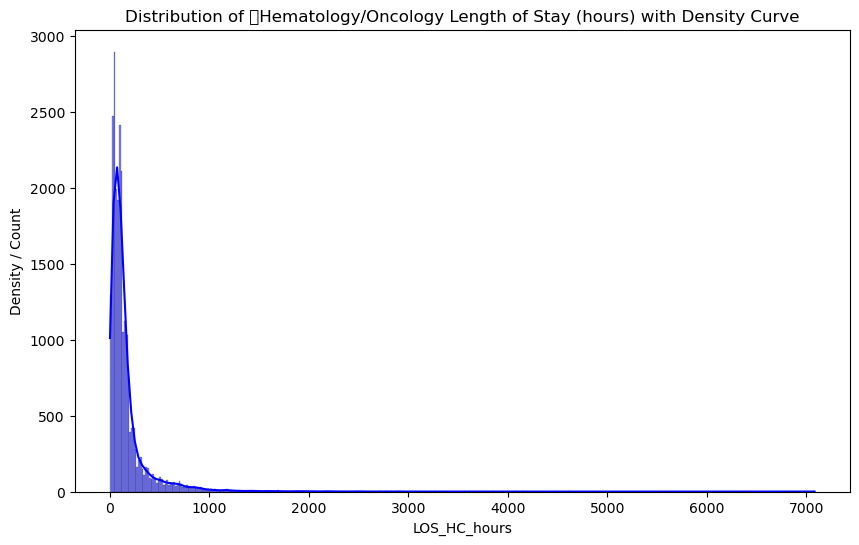

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
sns.histplot(df_transfers['LOS_HC_hours'], bins=400, kde=True, color='blue')
plt.title('Distribution of 	Hematology/Oncology Length of Stay (hours) with Density Curve')
plt.xlabel('LOS_HC_hours')
plt.ylabel('Density / Count')
plt.show()




In [84]:
df_transfers['LOS_HC_hours'].describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.95, 0.99])


count    23697.000000
mean       160.064819
std        241.137780
min          0.000000
25%         48.200000
50%         96.770000
75%        166.760000
90%        337.368000
95%        564.838000
99%       1129.972000
max       7082.300000
Name: LOS_HC_hours, dtype: float64

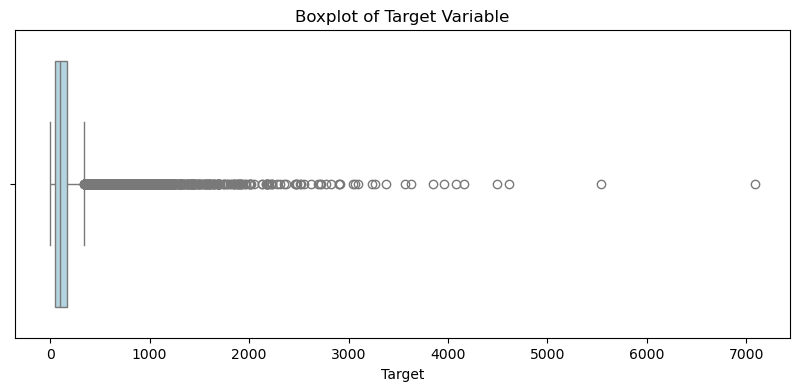

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))
sns.boxplot(x=df_transfers['LOS_HC_hours'], color='lightblue')
plt.title('Boxplot of Target Variable')
plt.xlabel('Target')
plt.show()


In [86]:
Q1 = df_transfers['LOS_HC_hours'].quantile(0.25)
Q3 = df_transfers['LOS_HC_hours'].quantile(0.75)
IQR = Q3 - Q1

upper_limit = Q3 + 1.5 * IQR
lower_limit = Q1 - 1.5 * IQR

outliers = df_transfers[(df_transfers['LOS_HC_hours'] > upper_limit) | (df_transfers['LOS_HC_hours'] < lower_limit)]
print(f"Outlier count: {len(outliers)} ({len(outliers)/len(df_transfers)*100:.2f}% of total)")


Outlier count: 2310 (9.75% of total)


In [87]:
upper_limit = df_transfers['LOS_HC_hours'].quantile(0.75) + 1.5 * (df_transfers['LOS_HC_hours'].quantile(0.75) - df_transfers['LOS_HC_hours'].quantile(0.25))
print("Upper limit (IQR method):", upper_limit)

df_transfers.loc[df_transfers['LOS_HC_hours'] > upper_limit, 'LOS_HC_hours'].describe()


Upper limit (IQR method): 344.59999999999997


count    2310.000000
mean      702.720255
std       470.861056
min       344.790000
25%       432.310000
50%       574.450000
75%       788.880000
max      7082.300000
Name: LOS_HC_hours, dtype: float64

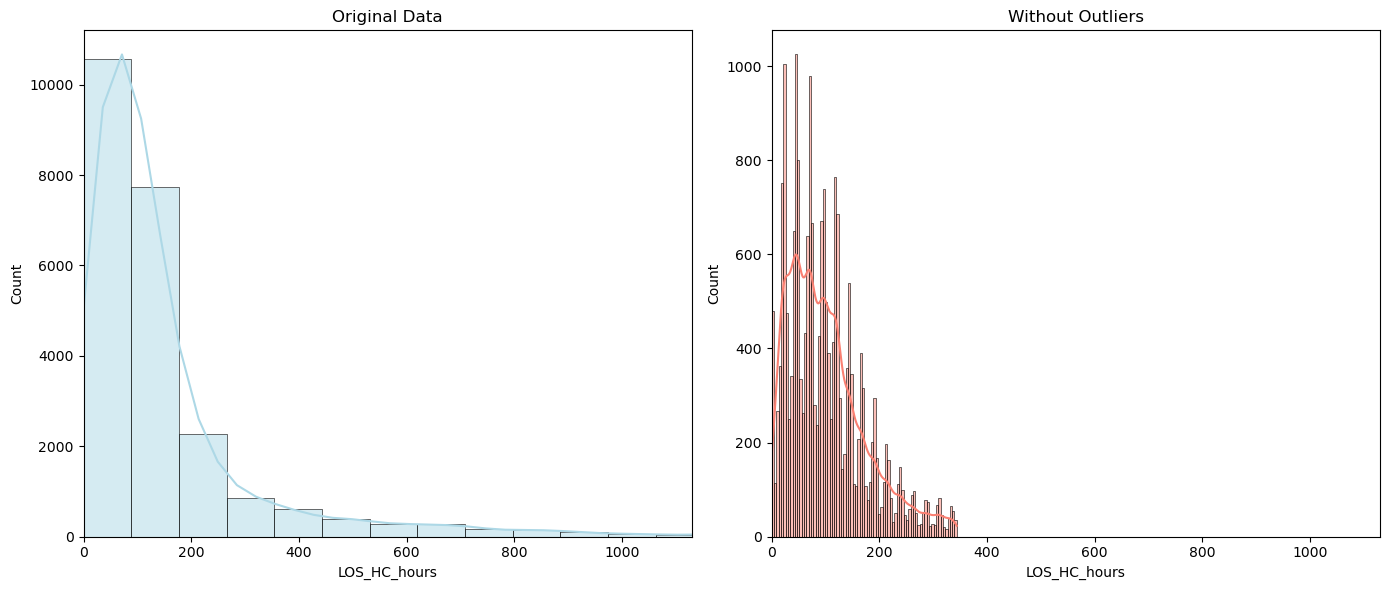

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Original
sns.histplot(df_transfers['LOS_HC_hours'], kde=True, bins=80, color='lightblue', stat='count', ax=axes[0])
axes[0].set_xlim(0, df_transfers['LOS_HC_hours'].quantile(0.99))
axes[0].set_title('Original Data')

# Without outliers
sns.histplot(df_transfers.loc[df_transfers['LOS_HC_hours'] <= upper_limit, 'LOS_HC_hours'], kde=True, bins=80, color='salmon', stat='count', ax=axes[1])
axes[1].set_xlim(0, df_transfers['LOS_HC_hours'].quantile(0.99))
axes[1].set_title('Without Outliers')

plt.tight_layout()
plt.show()


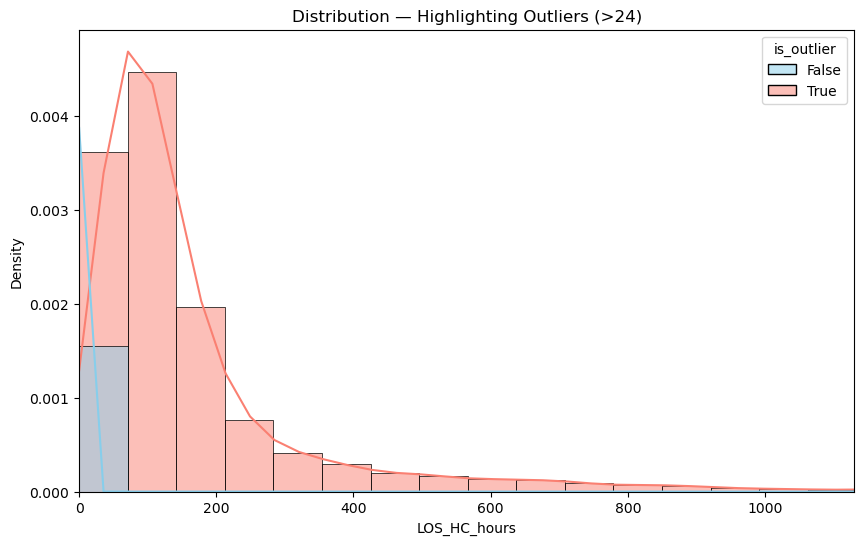

In [89]:
df_transfers['is_outlier'] = df_transfers['LOS_HC_hours'] > 24

plt.figure(figsize=(10,6))
sns.histplot(data=df_transfers, x='LOS_HC_hours', hue='is_outlier', bins=100, stat='density',
             palette={False: 'skyblue', True: 'salmon'}, kde=True)
plt.xlim(0, df_transfers['LOS_HC_hours'].quantile(0.99))
plt.title('Distribution — Highlighting Outliers (>24)')
plt.show()


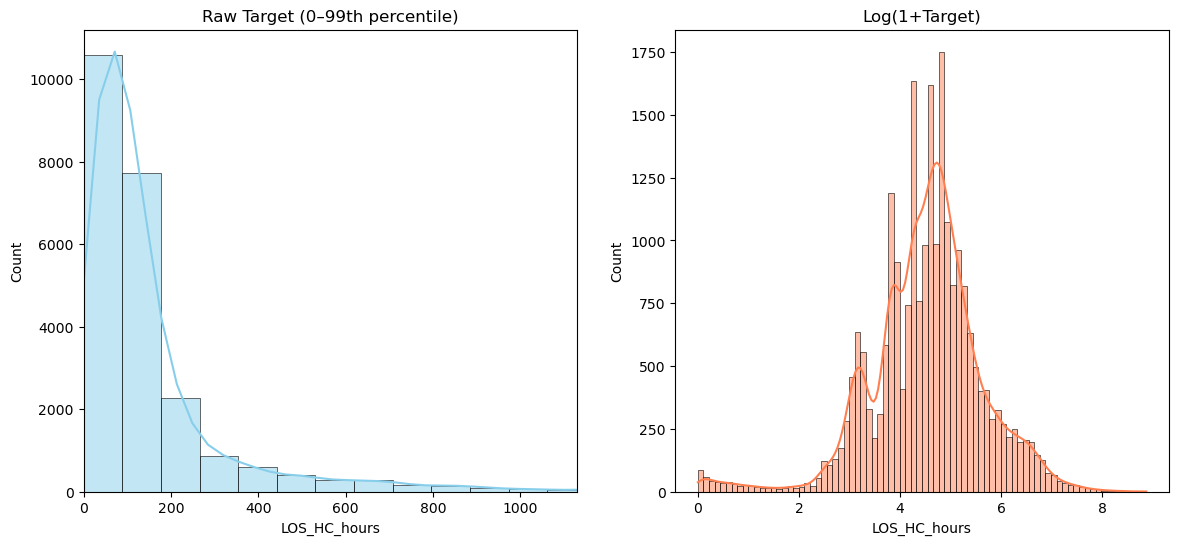

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.histplot(df_transfers['LOS_HC_hours'], kde=True, bins=80, stat='count', color='skyblue', ax=axes[0])
axes[0].set_xlim(0, df_transfers['LOS_HC_hours'].quantile(0.99))
axes[0].set_title('Raw Target (0–99th percentile)')

sns.histplot(np.log1p(df_transfers['LOS_HC_hours']), kde=True, bins=80, stat='count', color='coral', ax=axes[1])
axes[1].set_title('Log(1+Target)')

plt.show()


In [145]:
#print("df_transfers LOS range:", df_transfers["LOS_HC_hours"].min(), df_transfers["LOS_HC_hours"].max())
#print("df_merge2   LOS range:", df_merge2["LOS_HC_hours"].min(), df_merge2["LOS_HC_hours"].max())


df_transfers LOS range: 0.0 7082.3
df_merge2   LOS range: 0.01 3847.09


In [91]:
df_patients = pd.read_csv(r'C:\Users\arpitha_work\Downloads\TRU MSCDS\Sem 3\Graduate Project\MIMIC\mimic-iv-3.1\hosp\patients.csv')
df_patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364627 entries, 0 to 364626
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   subject_id         364627 non-null  int64 
 1   gender             364627 non-null  object
 2   anchor_age         364627 non-null  int64 
 3   anchor_year        364627 non-null  int64 
 4   anchor_year_group  364627 non-null  object
 5   dod                38301 non-null   object
dtypes: int64(3), object(3)
memory usage: 16.7+ MB


In [92]:
df_patients.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000058,F,33,2168,2020 - 2022,NaN
3,10000068,F,19,2160,2008 - 2010,NaN
4,10000084,M,72,2160,2017 - 2019,2161-02-13


In [93]:
df_patients.isnull().sum()

subject_id                0
gender                    0
anchor_age                0
anchor_year               0
anchor_year_group         0
dod                  326326
dtype: int64

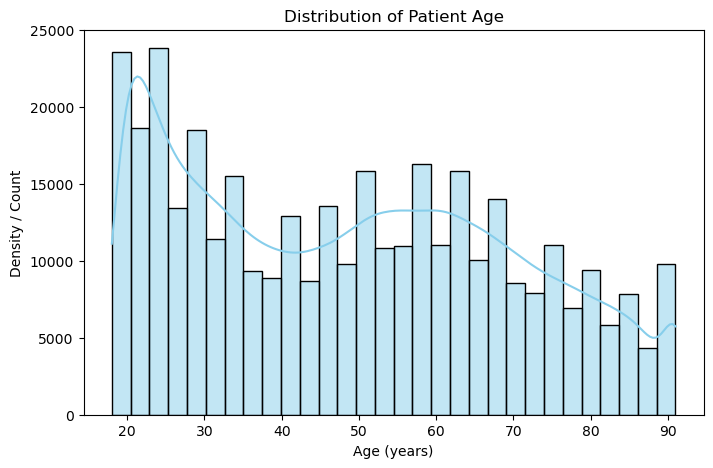

In [94]:
plt.figure(figsize=(8,5))
sns.histplot(df_patients['anchor_age'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Patient Age')
plt.xlabel('Age (years)')
plt.ylabel('Density / Count')
plt.show()


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_51768\3863528105.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gender', data=df_patients, palette='pastel')


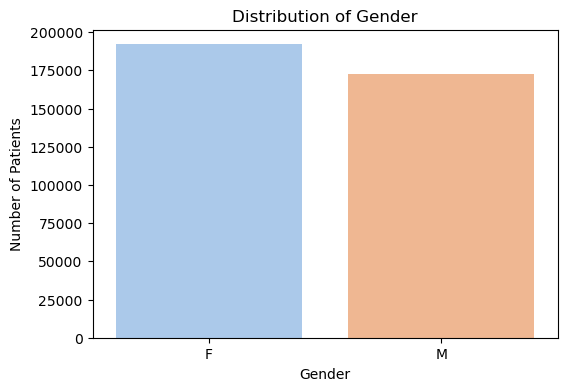

In [95]:
plt.figure(figsize=(6,4))
sns.countplot(x='gender', data=df_patients, palette='pastel')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Patients')
plt.show()


In [96]:
# lets keep only required columns in patients table
df_patients = df_patients.drop(columns=['anchor_year','anchor_year_group','dod'])

In [97]:
df_merge1=df_transfers.merge(df_patients,on='subject_id',how='left')
df_merge1.head()

,hadm_id,LOS_HC_hours,subject_id,is_outlier,gender,anchor_age
0,20000471.0,70.44,16207995,True,F,55
1,20001259.0,189.80,19179793,True,M,59
2,20001371.0,283.73,12591656,True,M,86
3,20001461.0,447.47,16725940,True,F,54
4,20002827.0,5.44,19602584,False,M,51


In [98]:
df_merge1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23697 entries, 0 to 23696
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hadm_id       23697 non-null  float64
 1   LOS_HC_hours  23697 non-null  float64
 2   subject_id    23697 non-null  int64  
 3   is_outlier    23697 non-null  bool   
 4   gender        23697 non-null  object 
 5   anchor_age    23697 non-null  int64  
dtypes: bool(1), float64(2), int64(2), object(1)
memory usage: 948.9+ KB


In [99]:
df_merge1=df_merge1[df_merge1['anchor_age'] >=65]
df_merge1.head()

,hadm_id,LOS_HC_hours,subject_id,is_outlier,gender,anchor_age
2,20001371.0,283.73,12591656,True,M,86
5,20003740.0,364.29,10995547,True,M,69
8,20006521.0,92.55,11234187,True,M,75
9,20006627.0,65.60,11055512,True,M,76
15,20009712.0,864.88,19125782,True,F,75


In [100]:
df_merge1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9643 entries, 2 to 23696
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hadm_id       9643 non-null   float64
 1   LOS_HC_hours  9643 non-null   float64
 2   subject_id    9643 non-null   int64  
 3   is_outlier    9643 non-null   bool   
 4   gender        9643 non-null   object 
 5   anchor_age    9643 non-null   int64  
dtypes: bool(1), float64(2), int64(2), object(1)
memory usage: 461.4+ KB


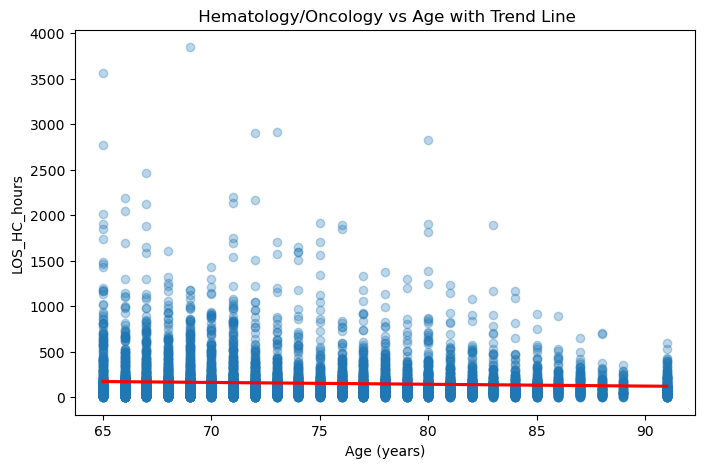

In [101]:
plt.figure(figsize=(8,5))
sns.regplot(x='anchor_age', y='LOS_HC_hours', data=df_merge1, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title(' Hematology/Oncology vs Age with Trend Line')
plt.xlabel('Age (years)')
plt.ylabel('LOS_HC_hours')
plt.show()


In [102]:
corr = df_merge1['anchor_age'].corr(df_merge1['LOS_HC_hours'])
print(f"Correlation between age and HC LOS: {corr:.2f}")


Correlation between age and HC LOS: -0.06


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_51768\4124000230.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gender', y='LOS_HC_hours', data=df_merge1, palette='viridis')


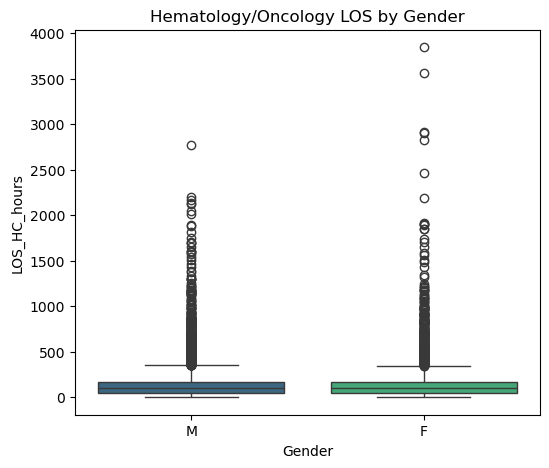

In [103]:
plt.figure(figsize=(6,5))
sns.boxplot(x='gender', y='LOS_HC_hours', data=df_merge1, palette='viridis')
plt.title('Hematology/Oncology LOS by Gender')
plt.xlabel('Gender')
plt.ylabel('LOS_HC_hours')
plt.show()


In [104]:
df_admissions = pd.read_csv(r'C:\Users\arpitha_work\Downloads\TRU MSCDS\Sem 3\Graduate Project\MIMIC\mimic-iv-3.1\hosp\admissions.csv')
df_admissions.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,English,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P784FA,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P19UTS,EMERGENCY ROOM,HOSPICE,Medicaid,English,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P06OTX,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P39NWO,EMERGENCY ROOM,NaN,NaN,English,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0


In [105]:
df_admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546028 entries, 0 to 546027
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   subject_id            546028 non-null  int64 
 1   hadm_id               546028 non-null  int64 
 2   admittime             546028 non-null  object
 3   dischtime             546028 non-null  object
 4   deathtime             11790 non-null   object
 5   admission_type        546028 non-null  object
 6   admit_provider_id     546024 non-null  object
 7   admission_location    546027 non-null  object
 8   discharge_location    396210 non-null  object
 9   insurance             536673 non-null  object
 10  language              545253 non-null  object
 11  marital_status        532409 non-null  object
 12  race                  546028 non-null  object
 13  edregtime             379240 non-null  object
 14  edouttime             379240 non-null  object
 15  hospital_expire_f

In [106]:
df_admissions = df_admissions.drop(columns=['dischtime','discharge_location','language',
                                            'edregtime','edouttime','hospital_expire_flag','deathtime'])

In [107]:
df_admissions = df_admissions.dropna(subset=['marital_status'])


In [108]:
df_admissions.isnull().sum()

subject_id               0
hadm_id                  0
admittime                0
admission_type           0
admit_provider_id        4
admission_location       0
insurance             8283
marital_status           0
race                     0
dtype: int64

In [109]:
df_admissions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 532409 entries, 0 to 546026
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   subject_id          532409 non-null  int64 
 1   hadm_id             532409 non-null  int64 
 2   admittime           532409 non-null  object
 3   admission_type      532409 non-null  object
 4   admit_provider_id   532405 non-null  object
 5   admission_location  532409 non-null  object
 6   insurance           524126 non-null  object
 7   marital_status      532409 non-null  object
 8   race                532409 non-null  object
dtypes: int64(2), object(7)
memory usage: 40.6+ MB


In [110]:
#lets understand about provider

df_admissions['admit_provider_id'].nunique()

2038

In [111]:
patients_per_doctor = df_admissions.groupby('admit_provider_id')['subject_id'].nunique().reset_index()
patients_per_doctor.rename(columns={'subject_id': 'unique_patients'}, inplace=True)

print(patients_per_doctor)

     admit_provider_id  unique_patients
0               P00230                1
1               P004G6               20
2               P005Y0                1
3               P00628              214
4               P007EI              107
...                ...              ...
2033            P99GVJ              408
2034            P99MV4              421
2035            P99V46              201
2036            P99X3Q               42
2037            P99Z33               23

[2038 rows x 2 columns]


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_51768\792934700.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='admission_type', data=df_admissions, palette='Set2')


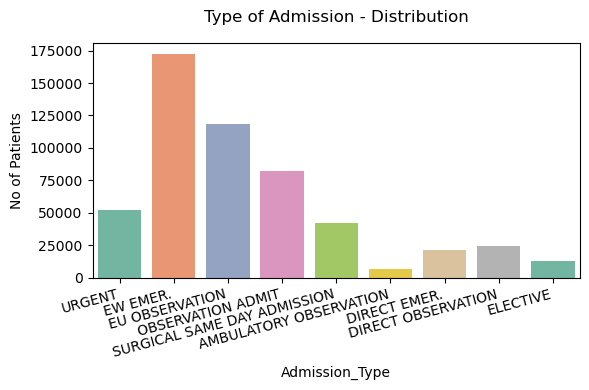

In [112]:
plt.figure(figsize=(6,4))
sns.countplot(x='admission_type', data=df_admissions, palette='Set2')
plt.title('Type of Admission - Distribution', pad=15)   
plt.xlabel('Admission_Type')
plt.ylabel('No of Patients')

# trying to rotate axis coz the titles were overlapping here
plt.xticks(rotation=15, ha='right') 
plt.tight_layout()
plt.show()


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_51768\1013477000.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='admission_location', data=df_admissions, palette='Set2')


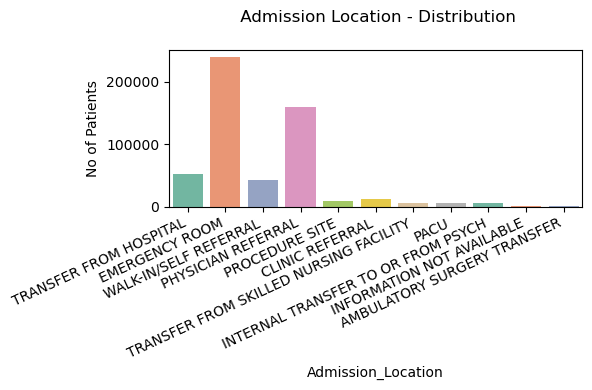

In [113]:
plt.figure(figsize=(6,4))
sns.countplot(x='admission_location', data=df_admissions, palette='Set2')
plt.title(' Admission Location - Distribution', pad=20)   
plt.xlabel('Admission_Location')
plt.ylabel('No of Patients')

# trying to rotate axis coz the titles were overlapping here
plt.xticks(rotation=25, ha='right') 
plt.tight_layout()
plt.show()


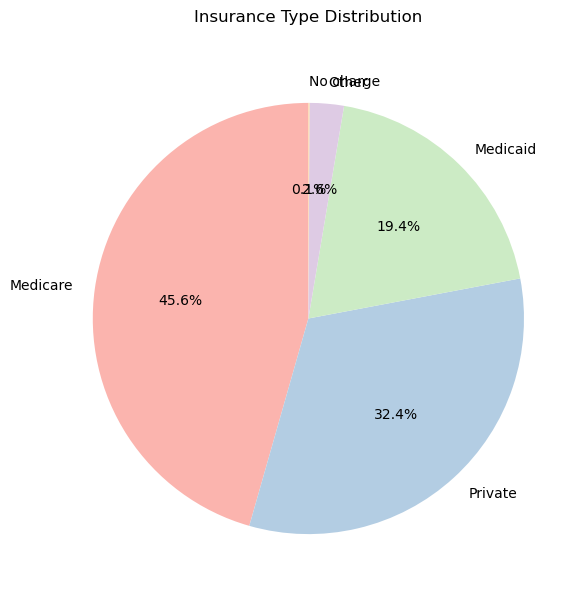

In [114]:
insurance_counts = df_admissions['insurance'].value_counts()

plt.figure(figsize=(7,7))
plt.pie(
    insurance_counts, 
    labels=insurance_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=plt.cm.Pastel1.colors
)
plt.title('Insurance Type Distribution', pad=20)
plt.show()


In [115]:
df_merge2 = pd.merge(df_merge1, df_admissions, on=['hadm_id','subject_id'], how='inner')
#using inner here instead of left coz i need matching records from both tables.

In [116]:
df_merge2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   hadm_id             9564 non-null   float64
 1   LOS_HC_hours        9564 non-null   float64
 2   subject_id          9564 non-null   int64  
 3   is_outlier          9564 non-null   bool   
 4   gender              9564 non-null   object 
 5   anchor_age          9564 non-null   int64  
 6   admittime           9564 non-null   object 
 7   admission_type      9564 non-null   object 
 8   admit_provider_id   9564 non-null   object 
 9   admission_location  9564 non-null   object 
 10  insurance           9557 non-null   object 
 11  marital_status      9564 non-null   object 
 12  race                9564 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(8)
memory usage: 906.1+ KB


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_51768\4271469205.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='insurance', x='LOS_HC_hours', data=df_merge2, palette='Set2')


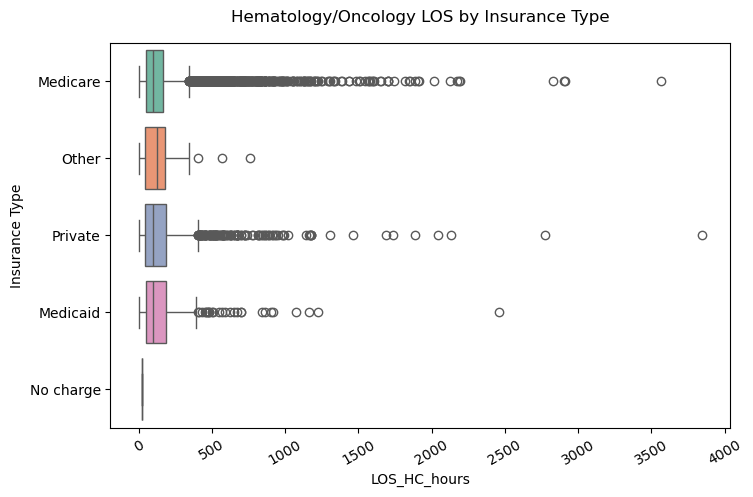

In [117]:
plt.figure(figsize=(8,5))
sns.boxplot(y='insurance', x='LOS_HC_hours', data=df_merge2, palette='Set2')
plt.title('Hematology/Oncology LOS by Insurance Type', pad=15)
plt.xlabel('LOS_HC_hours')
plt.ylabel('Insurance Type')
plt.xticks(rotation=30)  # Rotate labels if too long
plt.show()


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_51768\3457303300.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='admission_type', x='LOS_HC_hours', data=df_merge2, palette='Set2')


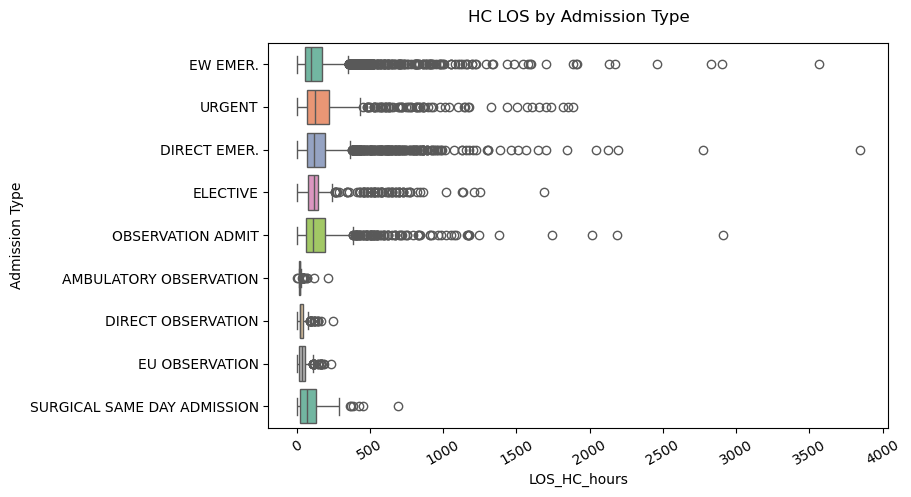

In [118]:
plt.figure(figsize=(8,5))
sns.boxplot(y='admission_type', x='LOS_HC_hours', data=df_merge2, palette='Set2')
plt.title('HC LOS by Admission Type', pad=15)
plt.xlabel('LOS_HC_hours')
plt.ylabel('Admission Type')
plt.xticks(rotation=30)  # Rotate labels if too long
plt.show()


In [119]:
df_merge2['LOS_HC_hours'].describe()

count    9564.000000
mean      153.578001
std       208.078692
min         0.000000
25%        49.162500
50%        97.360000
75%       168.532500
max      3847.090000
Name: LOS_HC_hours, dtype: float64

C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_51768\2072498758.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


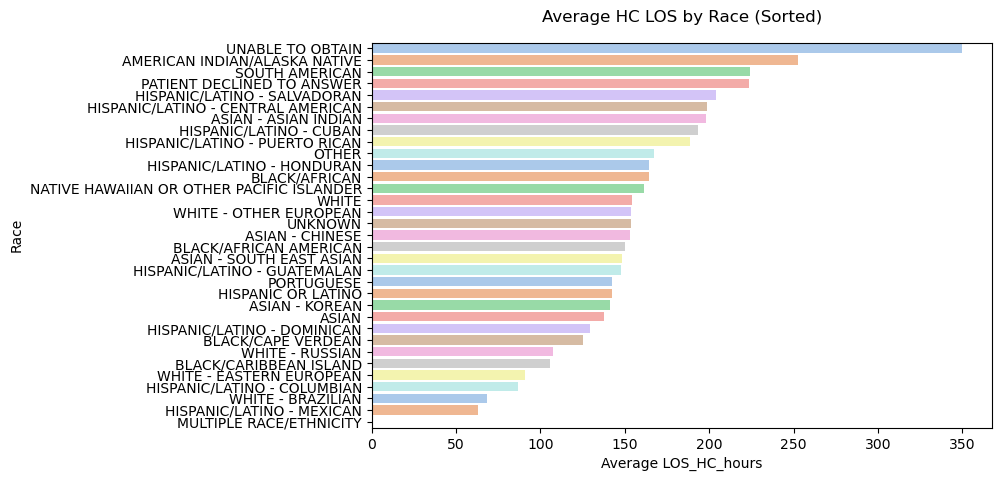

In [120]:
mean_los_race = df_merge2.groupby('race')['LOS_HC_hours'].mean().reset_index()
mean_los_race = mean_los_race.sort_values(by='LOS_HC_hours', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(
    y='race', 
    x='LOS_HC_hours', 
    data=mean_los_race,
    palette='pastel'
)
plt.title('Average HC LOS by Race (Sorted)', pad=15)
plt.xlabel('Average LOS_HC_hours')
plt.ylabel('Race')
plt.show()


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_51768\1698996254.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


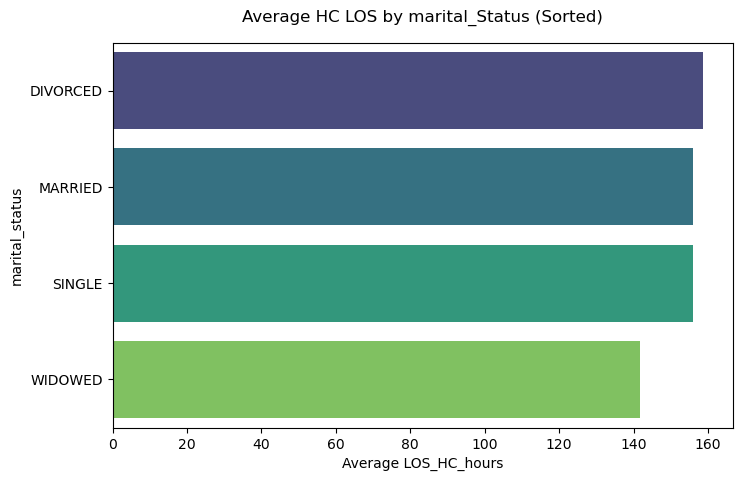

In [121]:
mean_los_race = df_merge2.groupby('marital_status')['LOS_HC_hours'].mean().reset_index()
mean_los_race = mean_los_race.sort_values(by='LOS_HC_hours', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(
    y='marital_status', 
    x='LOS_HC_hours', 
    data=mean_los_race,
    palette='viridis'
)
plt.title('Average HC LOS by marital_Status (Sorted)', pad=15)
plt.xlabel('Average LOS_HC_hours')
plt.ylabel('marital_status')
plt.show()


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_51768\1841652123.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


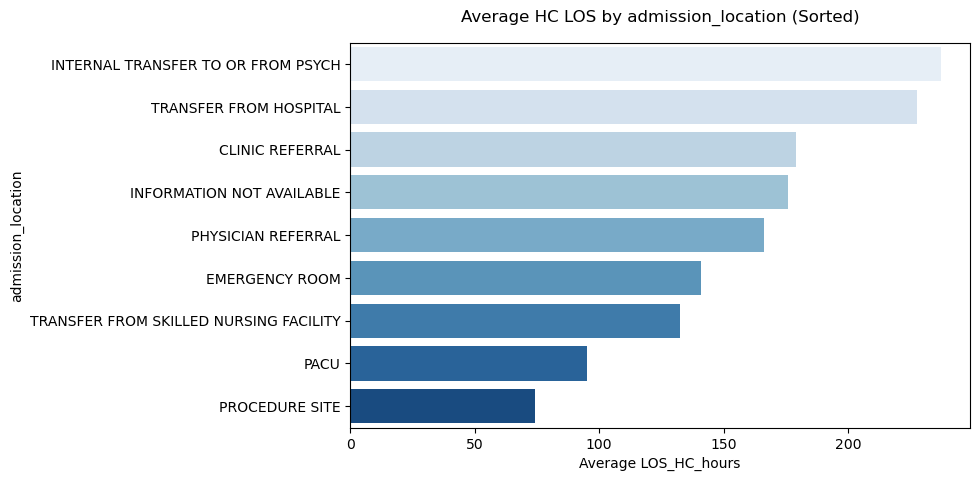

In [122]:
mean_los_race = df_merge2.groupby('admission_location')['LOS_HC_hours'].mean().reset_index()
mean_los_race = mean_los_race.sort_values(by='LOS_HC_hours', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(
    y='admission_location', 
    x='LOS_HC_hours', 
    data=mean_los_race,
    palette='Blues'
)
plt.title('Average HC LOS by admission_location (Sorted)', pad=15)
plt.xlabel('Average LOS_HC_hours')
plt.ylabel('admission_location')
plt.show()


In [123]:
df_merge2['admittime'] = pd.to_datetime(df_merge2['admittime'], errors='coerce')
df_merge2['admit_hour'] = df_merge2['admittime'].dt.hour
df_merge2['admit_day'] = df_merge2['admittime'].dt.dayofweek  # 0=Monday, 6=Sunday


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_51768\3740921247.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='admit_hour', y='LOS_HC_hours', data=df_merge2, palette='pastel')


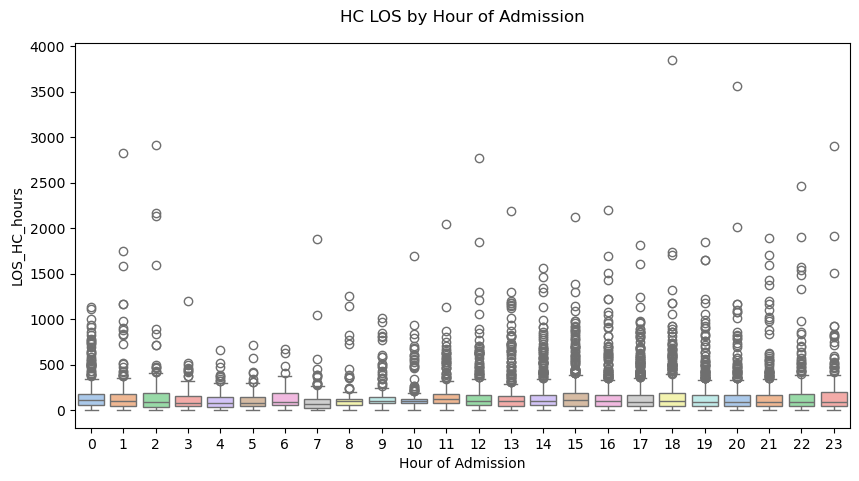

In [124]:
plt.figure(figsize=(10,5))
sns.boxplot(x='admit_hour', y='LOS_HC_hours', data=df_merge2, palette='pastel')
plt.title('HC LOS by Hour of Admission', pad=15)
plt.xlabel('Hour of Admission')
plt.ylabel('LOS_HC_hours')
plt.show()


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_51768\1575815197.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='admit_day', y='LOS_HC_hours', data=df_merge2, palette='Set2')


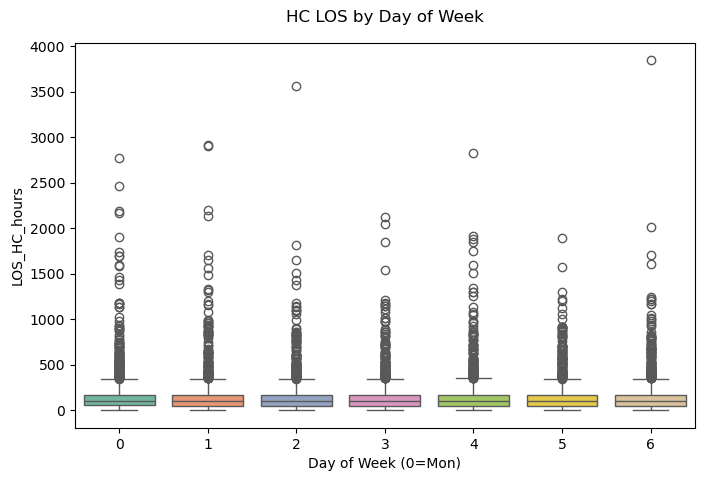

In [125]:
plt.figure(figsize=(8,5))
sns.boxplot(x='admit_day', y='LOS_HC_hours', data=df_merge2, palette='Set2')
plt.title('HC LOS by Day of Week', pad=15)
plt.xlabel('Day of Week (0=Mon)')
plt.ylabel('LOS_HC_hours')
plt.show()


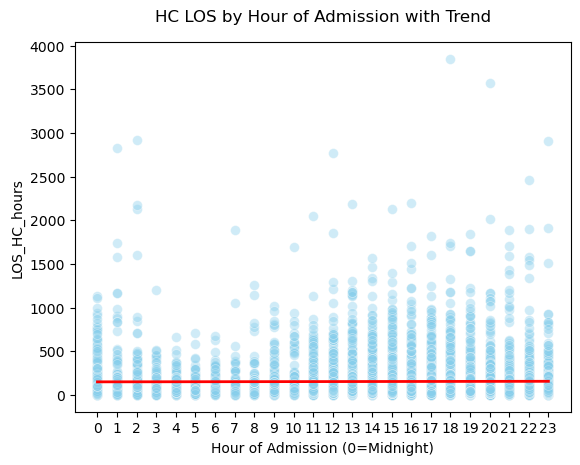

In [126]:
sns.scatterplot(
    x='admit_hour',
    y='LOS_HC_hours',
    data=df_merge2,
    color='skyblue',
    alpha=0.4,
    s=50
)

sns.regplot(
    x='admit_hour',
    y='LOS_HC_hours',
    data=df_merge2,
    scatter=False,          
    color='red',
    line_kws={'lw':2}
)

plt.title('HC LOS by Hour of Admission with Trend', pad=15)
plt.xlabel('Hour of Admission (0=Midnight)')
plt.ylabel('LOS_HC_hours')
plt.xticks(range(0,24))
plt.show()


In [127]:
file_path = r'C:\Users\arpitha_work\Downloads\TRU MSCDS\Sem 3\Graduate Project\MIMIC\mimic-iv-3.1\hosp\diagnoses_icd.csv.gz'
df_diagnoses = pd.read_csv(file_path, compression ='gzip')
df_diagnoses.head()


,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


In [128]:
print('There are {} unique ICD9 codes in this dataset.'.format(df_diagnoses['icd_code'].value_counts().count()))

There are 28562 unique ICD9 codes in this dataset.


In [129]:
def categorize_icd9_short(code):
    """Return short ICD-9 category name"""
    if pd.isna(code):
        return 'misc'
    
    code_str = str(code).strip().upper()
    if code_str.startswith(('E', 'V')):
        return 'misc'  
    
    try:
        num = int(code_str[:3])
    except ValueError:
        return 'misc'
    
    ranges = [
        ((1, 139), 'infectious'),
        ((140, 239), 'neoplasms'),
        ((240, 279), 'endocrine'),
        ((280, 289), 'blood'),
        ((290, 319), 'mental'),
        ((320, 389), 'nervous'),
        ((390, 459), 'circulatory'),
        ((460, 519), 'respiratory'),
        ((520, 579), 'digestive'),
        ((580, 629), 'genitourinary'),
        ((630, 679), 'pregnancy'),
        ((680, 709), 'skin'),
        ((710, 739), 'muscular'),
        ((740, 759), 'congenital'),
        ((760, 779), 'prenatal'),
        ((780, 799), 'misc'),
        ((800, 999), 'injury')
    ]
    
    for (low, high), label in ranges:
        if low <= num <= high:
            return label
    return 'misc'

In [130]:
df_diagnoses['icd_category'] = df_diagnoses['icd_code'].apply(categorize_icd9_short)

diag_counts = (
    df_diagnoses.groupby(['hadm_id', 'icd_category'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

In [131]:
df_merge2 = df_merge2.merge(diag_counts, on='hadm_id', how='left')

In [132]:

df_merge2.fillna(0, inplace=True)

for col in diag_counts.columns:
    if col != 'hadm_id':
        df_merge2[col] = df_merge2[col].astype(int)


print(df_merge2.shape)
df_merge2.info()

(9564, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   hadm_id             9564 non-null   float64       
 1   LOS_HC_hours        9564 non-null   float64       
 2   subject_id          9564 non-null   int64         
 3   is_outlier          9564 non-null   bool          
 4   gender              9564 non-null   object        
 5   anchor_age          9564 non-null   int64         
 6   admittime           9564 non-null   datetime64[ns]
 7   admission_type      9564 non-null   object        
 8   admit_provider_id   9564 non-null   object        
 9   admission_location  9564 non-null   object        
 10  insurance           9564 non-null   object        
 11  marital_status      9564 non-null   object        
 12  race                9564 non-null   object        
 13  admit_hour          9564 non-null   i

In [133]:
df_merge2.head()

,hadm_id,LOS_HC_hours,subject_id,is_outlier,gender,anchor_age,admittime,admission_type,admit_provider_id,admission_location,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,20001371.0,283.73,12591656,True,M,86,2184-02-10 14:37:00,EW EMER.,P95WSV,EMERGENCY ROOM,...,0,0,13,0,1,1,0,0,1,0
1,20003740.0,364.29,10995547,True,M,69,2160-09-07 13:14:00,EW EMER.,P42ETT,EMERGENCY ROOM,...,1,1,6,0,1,1,0,0,0,2
2,20006521.0,92.55,11234187,True,M,75,2176-05-02 17:39:00,URGENT,P163B7,TRANSFER FROM HOSPITAL,...,0,1,6,1,1,0,0,0,1,0
3,20006627.0,65.60,11055512,True,M,76,2169-02-22 23:19:00,EW EMER.,P70KX6,EMERGENCY ROOM,...,0,0,24,0,0,0,0,0,0,0
4,20009712.0,864.88,19125782,True,F,75,2177-11-09 15:02:00,DIRECT EMER.,P84909,PHYSICIAN REFERRAL,...,0,0,4,0,1,0,0,0,0,0


In [134]:
diseases = [
    'blood', 'circulatory', 'congenital', 'digestive', 'endocrine',
    'genitourinary', 'infectious', 'injury', 'mental', 'misc',
    'muscular', 'neoplasms', 'nervous', 'respiratory', 'skin'
]

mean_los = {}
for disease in diseases:
    mean_los[disease] = df_merge2.loc[df_merge2[disease] > 0, 'LOS_HC_hours'].mean()

C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_51768\3378971456.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=list(mean_los.keys()), y=list(mean_los.values()), palette='viridis')


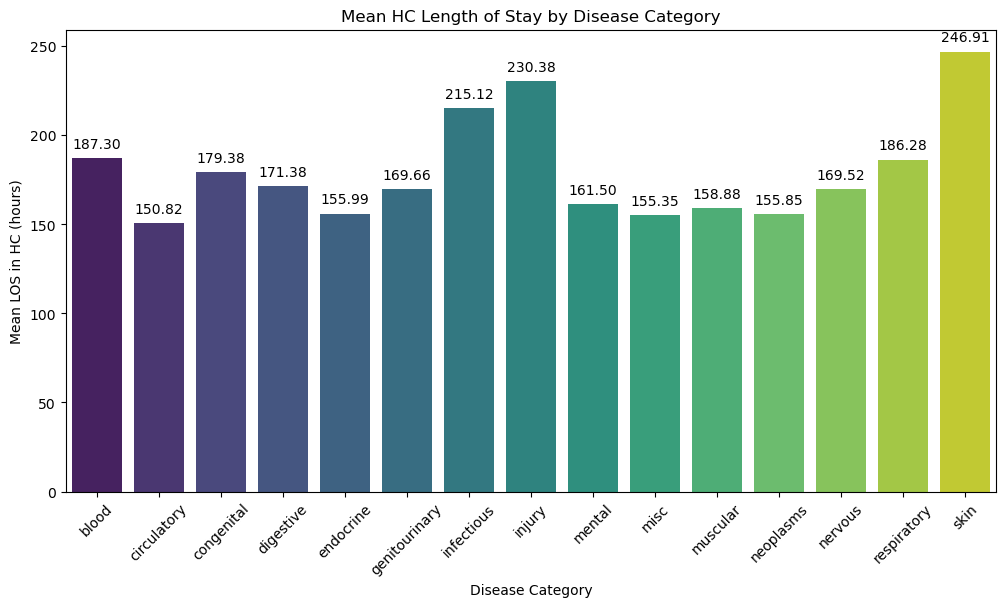

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
bars = sns.barplot(x=list(mean_los.keys()), y=list(mean_los.values()), palette='viridis')


for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{height:.2f}',  # 2 decimal places
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 5),  
                  textcoords='offset points',
                  ha='center', va='bottom')

plt.xticks(rotation=45)
plt.ylabel('Mean LOS in HC (hours)')
plt.xlabel('Disease Category')
plt.title('Mean HC Length of Stay by Disease Category')
plt.show()


In [136]:
df_merge2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   hadm_id             9564 non-null   float64       
 1   LOS_HC_hours        9564 non-null   float64       
 2   subject_id          9564 non-null   int64         
 3   is_outlier          9564 non-null   bool          
 4   gender              9564 non-null   object        
 5   anchor_age          9564 non-null   int64         
 6   admittime           9564 non-null   datetime64[ns]
 7   admission_type      9564 non-null   object        
 8   admit_provider_id   9564 non-null   object        
 9   admission_location  9564 non-null   object        
 10  insurance           9564 non-null   object        
 11  marital_status      9564 non-null   object        
 12  race                9564 non-null   object        
 13  admit_hour          9564 non-null   int32       

In [137]:
df_merge2.head()

,hadm_id,LOS_HC_hours,subject_id,is_outlier,gender,anchor_age,admittime,admission_type,admit_provider_id,admission_location,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,20001371.0,283.73,12591656,True,M,86,2184-02-10 14:37:00,EW EMER.,P95WSV,EMERGENCY ROOM,...,0,0,13,0,1,1,0,0,1,0
1,20003740.0,364.29,10995547,True,M,69,2160-09-07 13:14:00,EW EMER.,P42ETT,EMERGENCY ROOM,...,1,1,6,0,1,1,0,0,0,2
2,20006521.0,92.55,11234187,True,M,75,2176-05-02 17:39:00,URGENT,P163B7,TRANSFER FROM HOSPITAL,...,0,1,6,1,1,0,0,0,1,0
3,20006627.0,65.60,11055512,True,M,76,2169-02-22 23:19:00,EW EMER.,P70KX6,EMERGENCY ROOM,...,0,0,24,0,0,0,0,0,0,0
4,20009712.0,864.88,19125782,True,F,75,2177-11-09 15:02:00,DIRECT EMER.,P84909,PHYSICIAN REFERRAL,...,0,0,4,0,1,0,0,0,0,0


In [ ]:
""""Ensemble main - ED.ipynb"TARGET_COL = "LOS_HC_hours"


df_merge2 = df_merge2.copy()


df_merge2 = df_merge2[df_merge2[TARGET_COL].notna()].copy()
df_merge2 = df_merge2[df_merge2[TARGET_COL] > 0].copy()


cap_99 = df_merge2[TARGET_COL].quantile(0.99)
df_merge2["los_capped"] = df_merge2[TARGET_COL].clip(upper=cap_99)


df_merge2["los_log"] = np.log1p(df_merge2["los_capped"])

print("HC rows after cleaning:", len(df_merge2))
print("HC 99th percentile cap (hours):", cap_99)
print(df_merge2[[TARGET_COL, "los_capped", "los_log"]].describe())"""


HC rows after cleaning: 9562
HC 99th percentile cap (hours): 1000.4603999999957
       LOS_HC_hours   los_capped      los_log
count   9562.000000  9562.000000  9562.000000
mean     153.610123   148.423747     4.507101
std      208.088597   169.711983     1.105626
min        0.010000     0.010000     0.009950
25%       49.170000    49.170000     3.915417
50%       97.370000    97.370000     4.588736
75%      168.557500   168.557500     5.133192
max     3847.090000  1000.460400     6.909215


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


X = df_merge2.drop(columns=["LOS_HC_hours", "los_capped", "los_log", "hadm_id", "subject_id"], errors="ignore").copy()

y_log = df_merge2["los_log"].astype(float).copy()


if (y_log < 0).any():
    raise ValueError("Found negative los_log values, which should not happen after log1p on positive LOS.")


In [155]:
datetime_cols = X.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns.tolist()

for col in datetime_cols:
    dt = pd.to_datetime(X[col], errors="coerce")
    X[col + "_hour"] = dt.dt.hour
    X[col + "_weekday"] = dt.dt.weekday
    X[col + "_month"] = dt.dt.month

X.drop(columns=datetime_cols, inplace=True, errors="ignore")

cat_like = X.select_dtypes(include=["object", "string", "category"]).columns
X[cat_like] = X[cat_like].astype(str)
X[cat_like] = X[cat_like].replace({"nan": np.nan, "NaT": np.nan, "None": np.nan})


In [ ]:
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)


# y_train_log and y_test_log are already log targets.


In [ ]:
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())   
])


categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop",
    sparse_threshold=0.0   
)



In [ ]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge


rf = RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_leaf=5, random_state=42, n_jobs=1)
et = ExtraTreesRegressor(n_estimators=80, max_depth=10, min_samples_leaf=5, random_state=42, n_jobs=1)
gbr = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42)

ridge = Ridge(alpha=1.0, random_state=42)


voting = VotingRegressor(estimators=[("et", et), ("rf", rf), ("ridge", ridge), ("gbr", gbr)])
weighted_voting = VotingRegressor(estimators=[("et", et), ("rf", rf), ("ridge", ridge), ("gbr", gbr)],
                                  weights=[2, 1, 0.5, 3])

models = {
    "Ridge": ridge,
    "RandomForest": rf,
    "ExtraTrees": et,
    "GradientBoostingRegressor": gbr,
    "VotingRegressor": voting,
    "WeightedVotingRegressor": weighted_voting
}


In [ ]:
results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])

    print(f"\nTraining: {name}")
    pipe.fit(X_train, y_train_log)

    
    y_pred_log = pipe.predict(X_test)

    y_pred_hours = np.expm1(y_pred_log)
    y_pred_hours = np.clip(y_pred_hours, 0, None)

    
    y_test_hours = np.expm1(y_test_log)

 
    mse = mean_squared_error(y_test_hours, y_pred_hours)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_hours, y_pred_hours)
    r2_hours = r2_score(y_test_hours, y_pred_hours)

    
    r2_log = r2_score(y_test_log, y_pred_log)

    results[name] = {
        "MAE_hours": mae,
        "RMSE_hours": rmse,
        "MSE_hours": mse,
        "R2_hours": r2_hours,
        "R2_log": r2_log
    }

results_df = pd.DataFrame(results).T.sort_values("MAE_hours")
print("\n===== RESULTS (sorted by MAE_hours) =====")
print(results_df)



Training: Ridge

Training: KNN

Training: RandomForest

Training: ExtraTrees

Training: GradientBoostingRegressor

Training: VotingRegressor

Training: WeightedVotingRegressor

===== RESULTS (sorted by MAE_hours) =====
                           MAE_hours  RMSE_hours     MSE_hours  R2_hours  \
GradientBoostingRegressor  76.815916  149.797475  22439.283429  0.238921   
VotingRegressor            77.067231  151.512006  22955.887859  0.221399   
WeightedVotingRegressor    77.193189  151.639806  22994.630907  0.220085   
Ridge                      77.946425  149.105280  22232.384428  0.245939   
RandomForest               78.595781  154.237286  23789.140382  0.193138   
ExtraTrees                 79.207188  154.930282  24003.392297  0.185871   
KNN                        86.319084  164.927817  27201.184982  0.077411   

                             R2_log  
GradientBoostingRegressor  0.614889  
VotingRegressor            0.614058  
WeightedVotingRegressor    0.615144  
Ridge              

y_test_log range: 0.0196091059213221 2.068028486538341
y_test_hours range: 0.019802627296179712 6.909214613635148
y_pred_hours range: 0.053254932727376844 6.841115147153738


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor


rf_stack = RandomForestRegressor(
    n_estimators=120,
    max_depth=15,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=1
)

et_stack = ExtraTreesRegressor(
    n_estimators=180,
    max_depth=15,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=1
)

meta = Ridge(alpha=1.0, random_state=42)

simple_stacking = StackingRegressor(
    estimators=[("rf", rf_stack), ("et", et_stack)],
    final_estimator=meta,
    passthrough=False,
    cv=3,
    n_jobs=1
)

stack_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", simple_stacking)
])

print("\nTraining: SimpleStacking")
stack_pipe.fit(X_train, y_train_log)


y_pred_log_stack = stack_pipe.predict(X_test)


y_pred_hours_stack = np.expm1(y_pred_log_stack)
y_pred_hours_stack = np.clip(y_pred_hours_stack, 0, None)

y_test_hours = np.expm1(y_test_log)


mse = mean_squared_error(y_test_hours, y_pred_hours_stack)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_hours, y_pred_hours_stack)
r2_hours = r2_score(y_test_hours, y_pred_hours_stack)


r2_log = r2_score(y_test_log, y_pred_log_stack)

results["SimpleStacking"] = {
    "MAE_hours": mae,
    "RMSE_hours": rmse,
    "MSE_hours": mse,
    "R2_hours": r2_hours,
    "R2_log": r2_log
}

results_df = pd.DataFrame(results).T.sort_values("MAE_hours")
print("\n===== RESULTS (INCLUDING STACKING) =====")
print(results_df)



Training: SimpleStacking

===== RESULTS (INCLUDING STACKING) =====
                           MAE_hours  RMSE_hours     MSE_hours  R2_hours  \
GradientBoostingRegressor  76.815916  149.797475  22439.283429  0.238921   
VotingRegressor            77.067231  151.512006  22955.887859  0.221399   
WeightedVotingRegressor    77.193189  151.639806  22994.630907  0.220085   
SimpleStacking             77.519308  151.104679  22832.624096  0.225580   
Ridge                      77.946425  149.105280  22232.384428  0.245939   
RandomForest               78.595781  154.237286  23789.140382  0.193138   
ExtraTrees                 79.207188  154.930282  24003.392297  0.185871   
KNN                        86.319084  164.927817  27201.184982  0.077411   

                             R2_log  
GradientBoostingRegressor  0.614889  
VotingRegressor            0.614058  
WeightedVotingRegressor    0.615144  
SimpleStacking             0.616102  
Ridge                      0.560685  
RandomForest       

In [1]:
def end_signature():
    print("="*40)
    print("END OF NOTEBOOK — AT")
    print("="*40)

end_signature()


END OF NOTEBOOK — AT
